In [95]:
%matplotlib inline
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

In [96]:
from midox import midiread, midiwrite
import pretty_midi
import subprocess
import taglib
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink, Audio

from utils import NotesGenerationDataset, post_process_sequence_batch

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
output_file_name = 'output_classic_ed.mid'
weight_file_path = 'music_model_padfront_regularized_mlp.pth'

base_dataset_path = '../midi-Data/Classical/Wolfgang Amadeus Mozart'

major_notes = True

train = True
testing = True

one_time_size = 10

# DataLoader

In [99]:
trainset = NotesGenerationDataset(base_dataset_path, new_dataset=True, type='train')

trainset_loader = Data.DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True)

In [100]:
X = next(iter(trainset_loader))
print(X[0].shape)

keys_shape = X[0].shape[2]

torch.Size([1, 79999, 128])


In [101]:
if train:
    valset = NotesGenerationDataset(base_dataset_path, new_dataset=True, type='val')

    valset_loader = Data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [102]:
if train:
    X_val = next(iter(valset_loader))
    X_val[0].shape

# Utils

In [103]:
def validate(model, valset_loader, criterion_val):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0
    keys_shape = 88

    with torch.no_grad():
        for batch in tqdm(valset_loader):
            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable(output_sequences_batch.contiguous().view(-1).to(device))
            input_sequences_batch_var = Variable(input_sequences_batch.to(device))

            if sequences_lengths[0] > one_time_size:
                for i in range(sequences_lengths[0] - one_time_size - 1):
                    last_100_notes = input_sequences_batch_var[i:i+one_time_size, :, :]

                    out = model(last_100_notes)#.reshape(input_sequences_batch_var.shape[1], -1)

                    loss = criterion_val(out, input_sequences_batch_var[i+one_time_size].flatten())

                    full_val_loss += loss.item()
                    overall_sequence_length += sum(sequences_lengths)
            keys_shape = input_sequences_batch.shape[2]
    
    return full_val_loss / (overall_sequence_length * keys_shape)

In [104]:
def train_model(model, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=0.0, best_val_loss=float("inf"), clip=1.0, save=True, save_path = 'music_model_padfront_regularized.pth'):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        print("Epoch: ", epoch_number)
        for lr, batch in tqdm(zip(lrs_triangular, trainset_loader)):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable(output_sequences_batch.contiguous().view(-1).to(device))
            input_sequences_batch_var = Variable(input_sequences_batch.to(device))

            if sequences_lengths[0] > one_time_size:
                for i in range(sequences_lengths[0] - one_time_size-1):
                    optimizer.zero_grad()
                    last_100_notes = input_sequences_batch_var[i:i+one_time_size, :, :]

                    out = model(last_100_notes)

                    loss = criterion(out, input_sequences_batch_var[i+one_time_size].flatten())

                    loss_list.append(loss.item())
                    epoch_loss.append(loss.item())
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), clip)
                    optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model, valset_loader, criterion_val)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:
            if save:
                torch.save(model.state_dict(), save_path)
            best_val_loss = current_val_loss
    
    return best_val_loss

In [105]:
def test(model, testset_loader):
    model.eval()
    accuracies = []
    l = len(testset_loader)

    with torch.no_grad():
        for i, batch in enumerate(testset_loader):
            print(i+1, "/", l)
            acc = []
            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            input_sequences_batch_var = Variable(input_sequences_batch.to(device))

            non_zero_indices = np.argwhere(input_sequences_batch_var.cpu().numpy() > 0)[:, 0]

            for index in tqdm(np.unique(non_zero_indices)):
                if index >= sequences_lengths[0] - 1:
                    break
                if index > sequences_lengths[0] - one_time_size:
                    break
                out = model(input_sequences_batch_var[index:index+one_time_size].view(one_time_size, 1, 128))
                probabilities = nn.functional.softmax(out, dim=0)
                output = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
                output = Variable(output.float())

                a = input_sequences_batch_var.cpu().numpy()[1+index][0]
                b = output.squeeze(1).cpu().numpy()[0]

                distance = np.sum(a!=b)
                length = len(a)
                accuracy = 1 - (distance / length)
                acc.append(accuracy)

            accuracies.append(np.mean(accuracy))
    
    print(np.mean(accuracies))
    return np.mean(accuracies)

# RNN

In [106]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.flatten()
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [107]:
model = MLP(input_size=keys_shape*one_time_size, hidden_size=512, num_classes=keys_shape).to(device)

criterion = nn.CrossEntropyLoss().to(device)
criterion_val = nn.CrossEntropyLoss().to(device)

In [108]:
if train:
    validate(model, valset_loader, criterion_val)

100%|██████████| 16/16 [01:13<00:00,  4.62s/it]


In [109]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [120]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(model.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        print('Epoch %d' % epoch_number)
        for batch in tqdm(trainset_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).to(device) )
            input_sequences_batch_var = Variable( input_sequences_batch.to(device) )
            losses = []

            if sequences_lengths[0] > one_time_size:
                for i in range(sequences_lengths[0] - one_time_size-1):
                    last_100_notes = input_sequences_batch_var[i:i+one_time_size, :, :]

                    optimizer.zero_grad()
                    logits = model(last_100_notes)

                    loss = criterion(logits, input_sequences_batch_var[i+one_time_size].flatten())

                    loss.backward()
                    losses.append(loss.item())
                    nn.utils.clip_grad_norm_(model.parameters(), clip)
                    optimizer.step()

            loss_list.append(np.mean(losses))
            
            epoch_loss.append(np.mean(losses))
        
        print('Loss %.4f' % np.mean(epoch_loss))
        plt.plot(range(len(trainset_loader)), epoch_loss)
        plt.show()
    # plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0


  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 74/74 [11:19<00:00,  9.18s/it]

Loss 2.9848


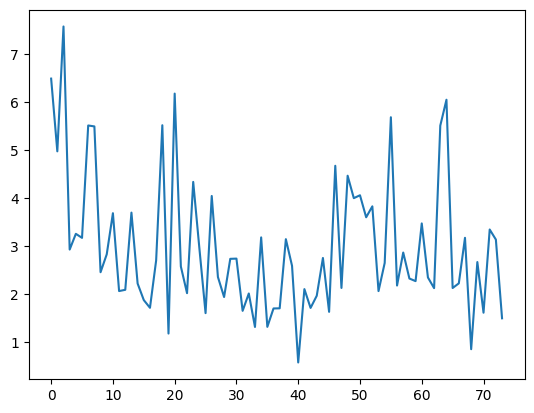

Epoch 1


100%|██████████| 74/74 [11:25<00:00,  9.26s/it]

Loss 3.0549


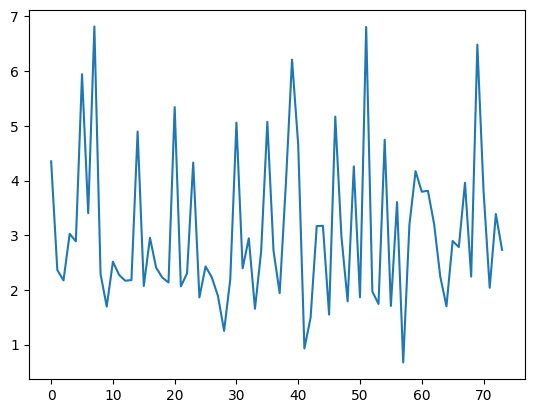

In [121]:
if train:
    rnn = MLP(input_size=keys_shape*one_time_size, hidden_size=512, num_classes=keys_shape).to(device)
    lrs, losses = lrfinder(1e-5, 5e-4, rnn, trainset_loader)

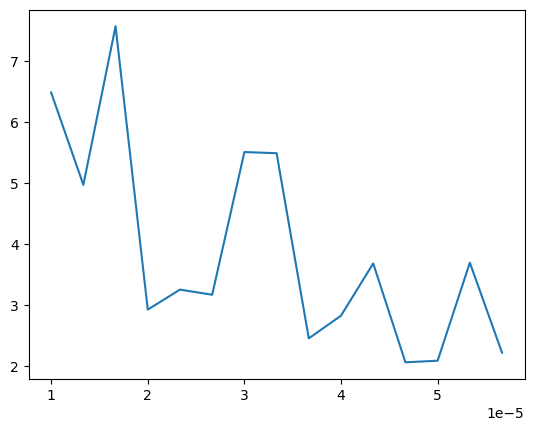

In [122]:
if train:
    plt.plot(lrs[:15], losses[:15])

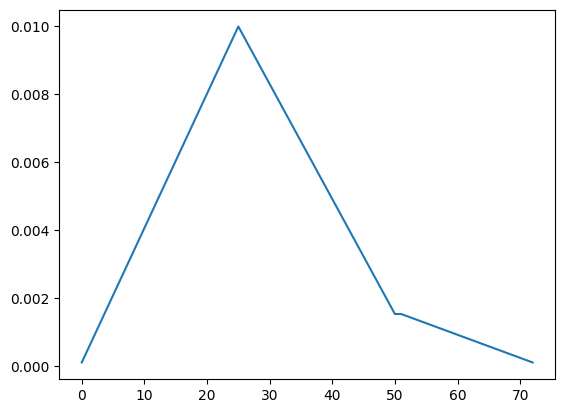

In [123]:
if train:
    def get_triangular_lr(lr_low, lr_high, mini_batches):
        iterations = mini_batches
        lr_mid = lr_high/7 + lr_low
        up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
        down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
        floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
        return np.hstack([up, down[1:], floor])

    lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
    plt.plot(lrs_triangular)

In [124]:
if train:
    mlp = MLP(input_size=keys_shape*one_time_size, hidden_size=512, num_classes=keys_shape).to(device)
    lrs_triangular = get_triangular_lr(1e-5, 5e-3, len(trainset_loader))
    best_val_loss = train_model(mlp, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, save_path=weight_file_path)

Epoch:  0


73it [12:34, 10.34s/it]


Training Loss: Epoch: 0 : 65659.64277103894


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Validation Loss: Epoch: 0 : 2.945845627076655e-06

Epoch:  1


73it [13:09, 10.82s/it]


Training Loss: Epoch: 1 : 77302.29096432045


100%|██████████| 16/16 [00:52<00:00,  3.30s/it]

Validation Loss: Epoch: 1 : 3.1374991324387405e-06



In [125]:
if train:
    lrs_triangular = get_triangular_lr(1e-5, 2e-3, len(trainset_loader))
    best_val_loss = train_model(mlp, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss, save_path=weight_file_path)

Epoch:  0


73it [12:58, 10.66s/it]


Training Loss: Epoch: 0 : 40047.43964960549


100%|██████████| 16/16 [00:32<00:00,  2.06s/it]


Validation Loss: Epoch: 0 : 2.0986252077622854e-06

Epoch:  1


13it [01:57,  6.36s/it]

In [ ]:
# if train:
#     lrs_triangular = get_triangular_lr(1e-4, 5e-3, len(trainset_loader))
#     best_val_loss = train_model(mlp, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss, save_path=weight_file_path)

: 

In [ ]:
mlp = MLP(input_size=keys_shape*one_time_size, hidden_size=512, num_classes=keys_shape).to(device)
mlp.load_state_dict(torch.load(weight_file_path))

: 

# Validation

In [ ]:
def sample_from_piano_rnn(model, sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, keys_shape)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.to(device))
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    model.eval()

    prev = 0

    i = 0

    while i < (sample_length + 10):
        output, hidden = model(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.divide(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = Variable(current_sequence_input.float())

        if not current_sequence_input.data.squeeze(1).cpu().numpy()[0].any():
            prev +=1
        else:
            prev = 0
        
        if prev >= 4:
            continue

        i+=1
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence[10:], dim=0).cpu().numpy()
    
    return sampled_sequence

: 

In [ ]:
testset =  NotesGenerationDataset(base_dataset_path, new_dataset=True, type='test')

testset_loader = Data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).to(device)

input_sequences_batch_var = input_sequences_batch.to(device)
input_sequences_batch_var.shape

: 

In [ ]:
def test(model, testset_loader):
    model.eval()
    accuracies = []
    l = len(testset_loader)

    with torch.no_grad():
        for i, batch in enumerate(testset_loader):
            print(i+1, "/", l)
            acc = []
            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            input_sequences_batch_var = Variable(input_sequences_batch.to(device))

            non_zero_indices = np.argwhere(input_sequences_batch_var.cpu().numpy() > 0)[:, 0]

            for index in tqdm(np.unique(non_zero_indices)):
                if index >= sequences_lengths[0] - 1:
                    break
                if index > sequences_lengths[0] - one_time_size:
                    break
                out = model(input_sequences_batch_var[index:index+one_time_size].view(one_time_size, 1, 128))
                probabilities = nn.functional.softmax(out, dim = 0)
                neg_probabilities = 1-probabilities
                binary_logits = torch.stack((neg_probabilities, probabilities), dim=1).contiguous()
                output = torch.multinomial(binary_logits.data, 1).squeeze()
                output = Variable(output.float())

                a = input_sequences_batch_var.cpu().numpy()[1+index][0]
                b = output.cpu().numpy()

                distance = np.sum(a!=b)
                length = len(a)
                accuracy = 1 - (distance / length)
                acc.append(accuracy)

            accuracies.append(np.mean(accuracy))
    
    print(np.mean(accuracies))
    return np.mean(accuracies), accuracies

In [ ]:
if test:
    test(mlp, testset_loader)

1 / 17


100%|█████████▉| 3830/3839 [00:03<00:00, 1182.49it/s]


2 / 17


100%|█████████▉| 14578/14587 [00:17<00:00, 841.34it/s]


3 / 17


100%|█████████▉| 26040/26049 [00:46<00:00, 561.08it/s]


4 / 17


100%|█████████▉| 4310/4319 [00:02<00:00, 1499.41it/s]


5 / 17


100%|█████████▉| 5931/5940 [00:04<00:00, 1270.41it/s]


6 / 17


100%|█████████▉| 7865/7874 [00:06<00:00, 1153.79it/s]


7 / 17


100%|█████████▉| 5475/5484 [00:04<00:00, 1309.34it/s]


8 / 17


100%|█████████▉| 3592/3601 [00:02<00:00, 1611.09it/s]


9 / 17


100%|█████████▉| 21890/21899 [00:34<00:00, 638.45it/s]


10 / 17


100%|█████████▉| 19890/19899 [00:30<00:00, 653.90it/s]


11 / 17


100%|█████████▉| 10970/10979 [00:10<00:00, 1024.17it/s]


12 / 17


100%|█████████▉| 2390/2399 [00:01<00:00, 1900.05it/s]


13 / 17


100%|█████████▉| 4310/4319 [00:02<00:00, 1548.38it/s]


14 / 17


100%|█████████▉| 11561/11570 [00:11<00:00, 1024.45it/s]


15 / 17


100%|█████████▉| 6270/6279 [00:04<00:00, 1318.83it/s]


16 / 17


100%|█████████▉| 9290/9299 [00:08<00:00, 1121.51it/s]


17 / 17


100%|█████████▉| 2340/2349 [00:01<00:00, 1277.06it/s]

0.9848345588235294


(0.9848345588235294,
 [0.984375,
  0.9765625,
  1.0,
  0.9921875,
  0.984375,
  0.984375,
  0.96875,
  0.9765625,
  0.9921875,
  0.984375,
  0.9765625,
  0.9921875,
  0.984375,
  1.0,
  0.9765625,
  0.9921875,
  0.9765625])

In [ ]:
plt.imshow(input_sequences_batch_var.cpu().numpy().reshape((input_sequences_batch_var.shape[0],keys_shape)).transpose(0,1))

: 

In [ ]:
piano_roll = sample_from_piano_rnn(mlp, sample_length=400, temperature=0.95, starting_sequence=input_sequences_batch_var[0].view(1,1,-1))
io.imshow(piano_roll.transpose())
plt.show()

: 

In [ ]:
midiwrite(output_file_name, piano_roll, dt=0.15, r=(0, 109))

# from pypianoroll import Multitrack, BinaryTrack
# piano_roll[:, 89:] = 0
# track_name = 'Piano'
# pianoroll_track = BinaryTrack(pianoroll=piano_roll, name=track_name)
# multitrack_name = 'MyMultitrack'  # Set a name for the multitrack
# multitrack = Multitrack(tracks=[pianoroll_track], name=multitrack_name, resolution=1)
# print(multitrack)
# multitrack.write('output.mid')

: 

In [ ]:
def is_major_note(note):
    # Check if the note is a major note (C, D, E, F, G, A, B)
    major_notes = [0, 2, 4, 5, 7, 9, 11]
    return note % 12 in major_notes
    # return True

def filter_major_notes(input_file, output_file):
    midi_data = pretty_midi.PrettyMIDI(input_file)

    for instrument in midi_data.instruments:
        # Keep only major notes in the instrument
        instrument.notes = [note for note in instrument.notes if is_major_note(note.pitch)]

    # Save the modified MIDI data to a new file
    midi_data.write(output_file)

if major_notes:
    filter_major_notes(output_file_name, output_file_name)

: 

In [ ]:
FileLink(output_file_name)

: 

In [ ]:
subprocess.run(['fluidsynth', '-ni', '-g', '1', '../IK_Berlin_Grand_Piano.sf2', output_file_name, '-F', ".".join(output_file_name.split('.')[:-1]) + '.wav'])

: 

In [ ]:
with taglib.File(".".join(output_file_name.split('.')[:-1]) + '.wav', save_on_exit=True) as song:
    song.tags["ALBUM"] = ["Music Generation"]
    song.tags["ARTIST"] = ["LSTM"]
    song.tags["TITLE"] = ["Generated Music"]

: 

In [ ]:
Audio(".".join(output_file_name.split('.')[:-1]) + '.wav')

: 

: 